# Car plate inference

In [21]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import carplate

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
CARPLATE_WEIGHTS_PATH = "mask_rcnn_carplate_0030.h5"  # TODO: update this path

# 车牌定位

In [3]:
config = carplate.CarplateConfig()
CARPLATE_DIR = os.path.join(ROOT_DIR, "datasets/carplate")

In [5]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [7]:
# Load validation dataset
dataset = carplate.CarplateDataset()
dataset.load_carplate(CARPLATE_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 50
Classes: ['BG', 'carplate']


## Load Mask-RCNN Model

In [8]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
# Load weights
weights_path = CARPLATE_WEIGHTS_PATH
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  mask_rcnn_carplate_0030.h5


## Run Detection

image ID: carplate.粤BR75Y3.jpg (49) /home/xiechao/桌面/car/datasets/carplate/val/粤BR75Y3.jpg


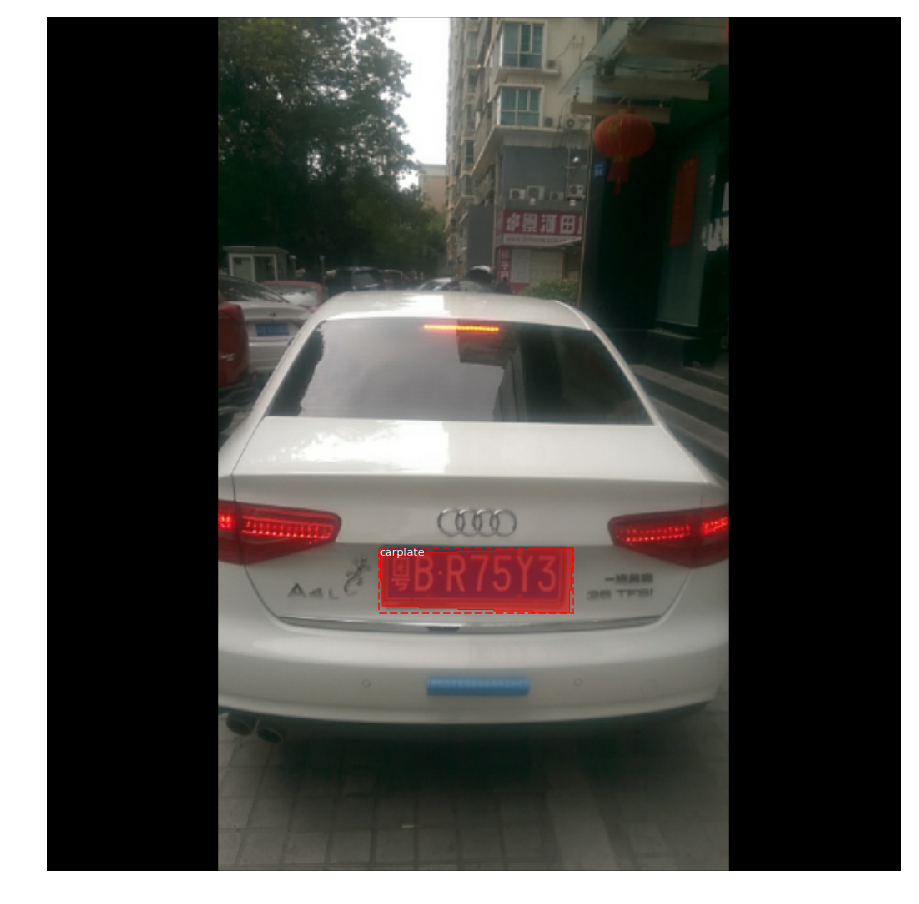

In [16]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, dataset.class_names)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


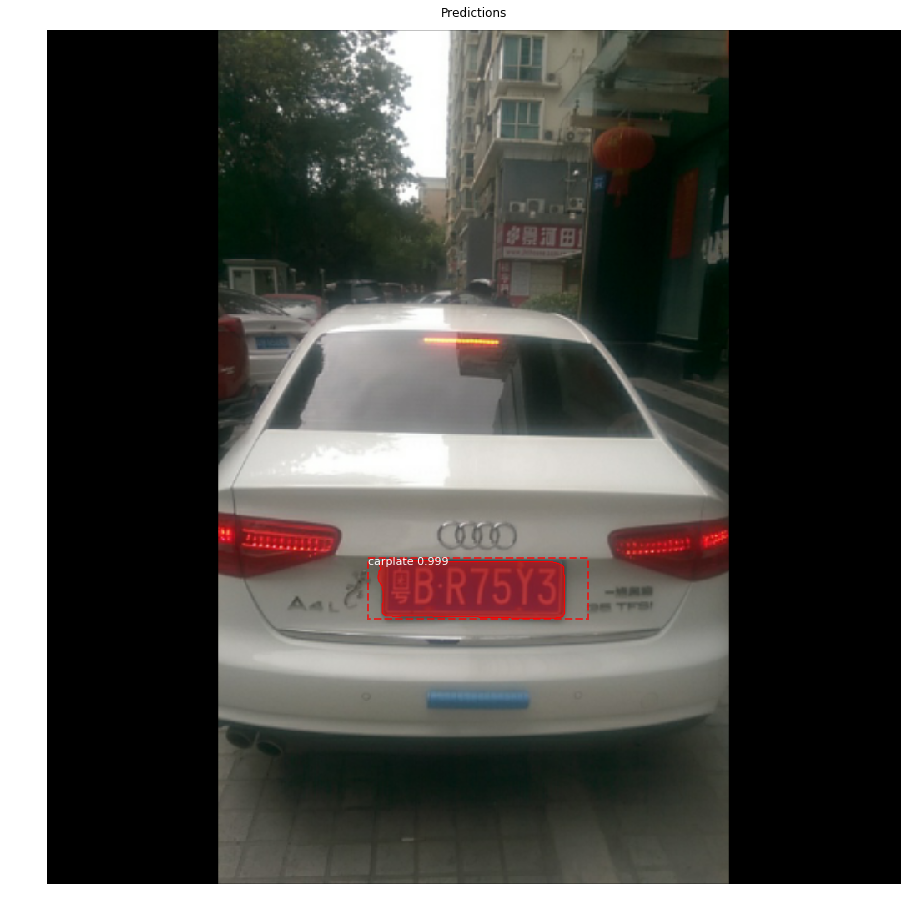

In [17]:
results = model.detect([image], verbose=1)
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

In [18]:
# 假设只有一个车牌

p = r['masks'].flatten()
p0 = np.where(p == True)[0][0]
p1 = np.where(p == True)[0][-1]

In [19]:
x0 = p0//image.shape[0]
y0 = p0%image.shape[0]
x1 = p1//image.shape[0]
y1 = p1%image.shape[0]

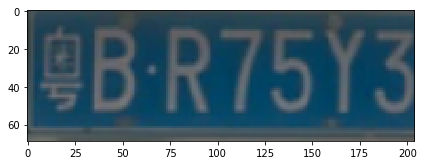

In [20]:
skimage.io.imshow(image[x0:x1, y0:y1])

# 字符分割

In [23]:
img = image[x0:x1, y0:y1]

In [27]:
def split_x(img):
    skimage.io.imshow(img)
    ban = []
    last_i = 0
    for i in range(img.shape[1]):
        c = np.count_nonzero(img[:, i] < .3)
        if c > img.shape[0]*.8:
            if i - last_i > 3:
                plt.plot([last_i,last_i], [0,img.shape[0]], c='yellow')
                plt.plot([i,i], [0,img2.shape[0]], c='green')
                ban.append((last_i,i))

            last_i = i
    if i != last_i:
        plt.plot([last_i,last_i], [0,img.shape[0]], c='yellow')
        plt.plot([i,i], [0,img.shape[0]], c='green')
        ban.append((last_i,i))

    chars = []
    for y0, y1 in ban:
        img_sub = img[:, y0:y1]
        chars.append(img_sub)
    return chars

def split_y(img):
    plt.figure()
    skimage.io.imshow(img)
    
    last_i = 0
    ban = []
    for i in range(img.shape[0]):
        c = np.count_nonzero(img[i,:] < .3)
        if c > img.shape[1]*.9:
            if i - last_i > 3:
                plt.plot([0, img.shape[1]],[last_i,last_i], c='yellow')
                plt.plot([0, img.shape[1]],[i,i], c='green')
                ban.append((last_i, i))
            last_i = i
    if i != last_i:
        plt.plot([0, img.shape[1]],[last_i,last_i], c='yellow')
        plt.plot([0, img.shape[1]],[i,i], c='green')
        ban.append((last_i, i))
    
    for r0, r1 in ban:
        if r1 - r0 < img.shape[0]/3:
            continue

        img2 = img[r0:r1,:]
        s_max = max(img2.shape)

        pad_w = int((s_max - img2.shape[0])/2)
        pad_h = int((s_max - img2.shape[1])/2)

        img2 = np.pad(img2, ((pad_w,pad_w), (pad_h,pad_h)), mode='constant', constant_values=np.mean(img))
        img2 = skimage.transform.resize(img2, (20,20), mode='reflect', anti_aliasing=True)
        
        return img2

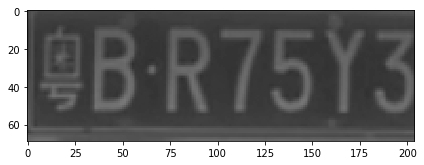

In [25]:
img2 = skimage.color.rgb2gray(img)
skimage.io.imshow(img2)

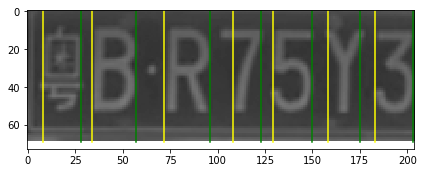

In [26]:
chars = split_x(img2)

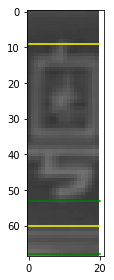

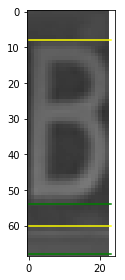

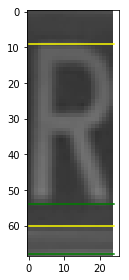

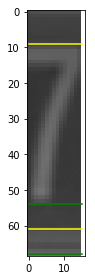

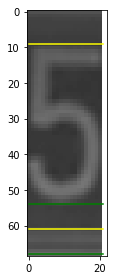

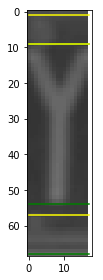

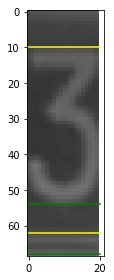

In [28]:
chars2 = np.array([split_y(c) for c in chars])

# 字符识别

In [37]:
DATASET_DIR = 'dataset/carplate'
classes = os.listdir(DATASET_DIR + "/ann/")

num_classes = len(classes)
img_rows, img_cols = 20, 20

if K.image_data_format() == 'channels_first':
    input_shape = [1, img_rows, img_cols]
else:
    input_shape = [img_rows, img_cols, 1]

In [38]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [39]:
model.load_weights("char_cnn.h5")

In [40]:
def extend_channel(data):
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        
    return data

In [43]:
ys = np.unique(classes)

p_test = model.predict_classes(extend_channel(chars2))
print(' '.join([ys[p_test[i]] for i in range(len(p_test))]))

zh_yue B R 7 5 Y 3
